# Simulating the 100 Prisoners Riddle

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/100_prisoners_problem_qtl1.svg/1920px-100_prisoners_problem_qtl1.svg.png" alt="Girl in a jacket" width="400" height="300">

The director of a prison offers 100 death row prisoners, who are numbered from 1 to 100, a last chance.
- A room contains a cupboard with 100 drawers.
- The director randomly puts one prisoner's number in each closed drawer.
- The prisoners enter the room, one after another. Each prisoner may open and look into 50 drawers in any order.
- The drawers are closed again afterwards. 

To Succeed:
1. Every prisoner finds their number in one of the drawers, all prisoners are pardoned.
2. If just one prisoner does not find their number, all prisoners die.

Before the first prisoner enters the room, the prisoners may discuss strategy — but may not communicate once the first prisoner enters to look in the drawers. What is the prisoners' best strategy?

In [33]:
import pandas as pd
import numpy as np
from tqdm import trange

In [122]:
def shuffle_boxes(n_prisoners=100):
    """
    Shuffles the prisoner numbers in drawers
    """
    prisoners = [x for x in range(0, n_prisoners)]
    boxes = {}
    np.random.shuffle(prisoners)
    for i, p in enumerate(prisoners):
        boxes[i] = p
    return boxes

boxes = shuffle_boxes()
prisoners = [x for x in range(0, 100)]
box_numbers = [x for x in range(0, 100)]

# Rules of the Game:
- Each Prisoner can select from up to 50 boxes to find their number.

In [8]:
prisoner = 1

In [31]:
def random_select(prisoner_number, boxes):
    for choice in np.random.choice(box_numbers, size=50):
        if boxes[choice] == prisoner_number:
            return True
    return False

In [34]:
results = {}
for x in trange(5_000):
    boxes = shuffle_boxes()
    n_correct = 0
    for prisoner in prisoners:
        correct = random_select(prisoner_number=prisoner, boxes=boxes)
        if correct:
            n_correct += 1
    results[x] = n_correct

100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 230.34it/s]


<AxesSubplot:title={'center':'Number of Sucessful Prisoners'}, ylabel='Frequency'>

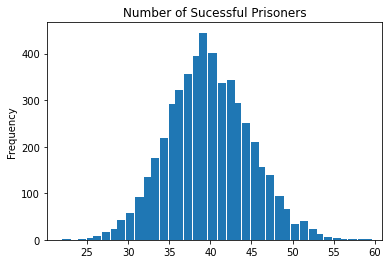

In [47]:
df = pd.DataFrame.from_dict(results, orient='index', columns=['ncorrect'])
df['ncorrect'].plot(kind='hist', bins=100, width=1, title='Number of Sucessful Prisoners')

In [43]:
# Chance of survival!
(0.5)**100

7.888609052210118e-31

In [42]:
0.00000000000000000000000000000078

7.8e-31

# Improve Chance to 1/3
- Best strategy:
    - Each prisoner first starts with their own numbered box.
    - If the number in that box is not theirs, they open the box for that number.
    - and so on to 50.

Open your box, then open the next

In [123]:
def loop_select(prisoner_number, boxes, ntries=50):
    next_box = prisoner_number
    for x in range(ntries):
        if boxes[next_box] == prisoner_number:
            return True
        next_box = boxes[next_box]
    return False

In [118]:
results = {}
for x in trange(5_000):
    boxes = shuffle_boxes()
    n_correct = 0
    for prisoner in prisoners:
        correct = loop_select(prisoner_number=prisoner, boxes=boxes)
        if correct:
            n_correct += 1
    results[x] = n_correct

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2468.04it/s]


<AxesSubplot:title={'center':'Number of Sucessful Prisoners'}, ylabel='Frequency'>

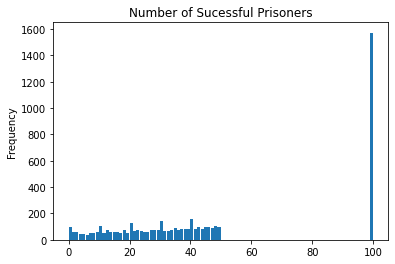

In [119]:
df = pd.DataFrame.from_dict(results,
                            orient='index',
                            columns=['ncorrect'])

df['ncorrect'].plot(kind='hist', bins=90, width=1,
                    title='Number of Sucessful Prisoners')

In [121]:
df['success'] = df['ncorrect'] == 100
df['success'].mean()

0.3144

# 1000 prisoners instead, does it hold?

In [135]:
results = {}
prisoners = [x for x in range(0, 1_000)]

for x in trange(500):
    boxes = shuffle_boxes(1_000)
    n_correct = 0
    for prisoner in prisoners:
        correct = loop_select(prisoner_number=prisoner, boxes=boxes,
                             ntries=500)
        if correct:
            n_correct += 1
    results[x] = n_correct

100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.85it/s]


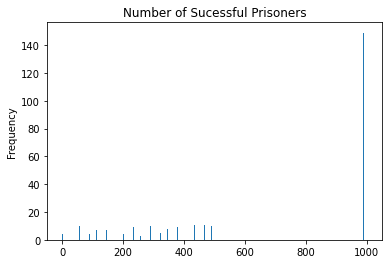

In [138]:
df = pd.DataFrame.from_dict(results,
                            orient='index',
                            columns=['ncorrect'])

df['ncorrect'].plot(kind='hist', bins=90, width=1,
                    title='Number of Sucessful Prisoners')
plt.show()

In [139]:
df['success'] = df['ncorrect'] == 1000
df['success'].mean()

0.298

# HOW DOES THIS WORK?!

- The Box Loops

In [143]:
import networkx as nx
import matplotlib.pyplot as plt

prisoners = [x for x in range(0, 100)]
boxes = shuffle_boxes()
G = nx.Graph()
G.add_nodes_from(prisoners)

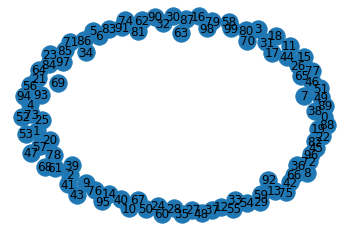

In [144]:
subax1 = plt.subplots()
nx.draw(G, with_labels=True)

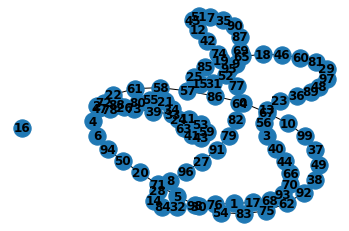

In [145]:
edges = [(x,y) for x, y in boxes.items()]
G.add_edges_from(edges, weight=1)

subax1 = plt.subplots()
nx.draw(G, with_labels=True, font_weight='bold')

# Color Loops

In [146]:
import seaborn as sns
color_pal = sns.color_palette()

In [147]:
cycles = nx.cycle_basis(G.to_undirected())
for group in cycles:
    for mybox in group:
        break

In [148]:
group_dict = {}
for i, c in enumerate(cycles):
    group_dict[i] = c

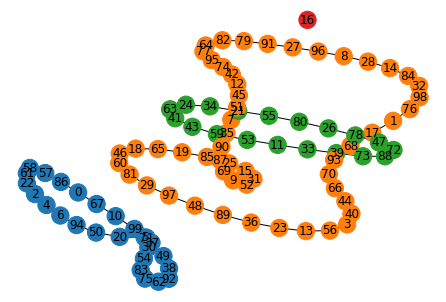

In [169]:
color_map = []
for node in G:
    for i in range(50):
        if node in group_dict[i]:
            color_map.append(color_pal[i])
            break
            
pos = nx.layout.fruchterman_reingold_layout(G)

nx.draw(G, pos, node_color=color_map, with_labels=True)
plt.show()

# Simulate Loops

In [170]:
boxes = shuffle_boxes()
def get_max_loop(boxes):
    G = nx.Graph()
    G.add_nodes_from(prisoners)
    edges = [(x,y) for x, y in boxes.items()]
    G.add_edges_from(edges, weight=1)
    cycles = nx.cycle_basis(G.to_undirected())
    max_loop = max([len(x) for x in cycles])
    return max_loop

100%|█████████████████████████████████████████████████████████████████████| 50000/50000 [01:19<00:00, 625.02it/s]


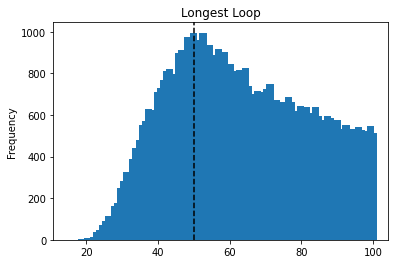

In [228]:
results = {}
for i in trange(50_000):
    boxes = shuffle_boxes()
    results[i] = get_max_loop(boxes)

df_maxloop = pd.DataFrame.from_dict(results, orient='index', columns=['max_loop'])
ax = df_maxloop['max_loop'].plot(kind='hist',
                            bins=100, width=2,
                            title='Longest Loop')
ax.axvline(50, color='black', ls='--')

<AxesSubplot:>

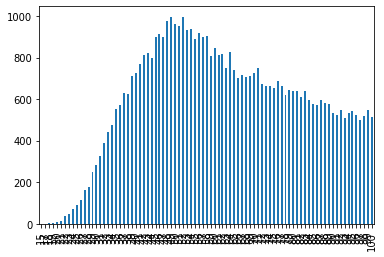

In [232]:
df_maxloop['max_loop'].value_counts().sort_index().plot(kind='bar')

# Plot Random Loops Success vs Fail

In [224]:
def plot_loops(boxes, prisoners):
    fig, ax = plt.subplots()
    G = nx.Graph()
    G.add_nodes_from(prisoners)
    edges = [(x,y) for x, y in boxes.items()]
    G.add_edges_from(edges, weight=1)
    cycles = nx.cycle_basis(G.to_undirected())
    group_dict = {}
    for i, c in enumerate(cycles):
        group_dict[i] = c

    color_map = []
    for node in G:
        for i in range(50):
            try:
                if node in group_dict[i]:
                    color_map.append(color_pal[i])
                    break
            except KeyError:
                pass
    nx.draw(G, ax=ax, node_color=color_map, with_labels=True)
    return ax

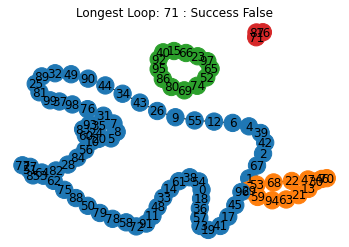

ValueError: 'c' argument has 98 elements, which is inconsistent with 'x' and 'y' with size 100.

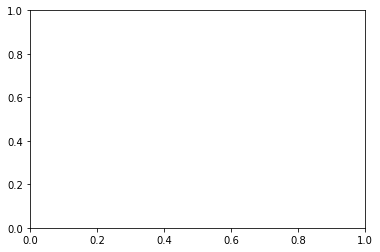

In [225]:
for i in range(15):
    boxes = shuffle_boxes()
    ax = plot_loops(boxes, prisoners)
    max_loop = get_max_loop(boxes)

    success = max_loop <= 50

    ax.set_title(f'Longest Loop: {max_loop} : Success {success}')
    plt.show()

In [217]:
[x for x in ax[3] if x == 46]

[]